In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, mean_squared_error, roc_auc_score, accuracy_score, classification_report, roc_curve, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import lime
from lime.lime_tabular import LimeTabularExplainer


pd.options.mode.chained_assignment = None

def find_best_threshold(thresholds, fpr, tpr):
    """
    find the best threshold from the roc curve. by finding the threshold for the point which is closest to (fpr=0,tpr=1)
    """
    fpr_tpr = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr})
    fpr_tpr['dist'] = (fpr_tpr['fpr'])**2 + (fpr_tpr['tpr']-1)**2
    return fpr_tpr.loc[fpr_tpr.dist.idxmin(), 'thresholds']


def get_model_results(model, train, test, y_train, y_test):
    probabilities = model.predict_proba(test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    threshold = find_best_threshold(thresholds, fpr, tpr)
    predictions = probabilities>threshold
    plt.figure()
    plt.plot(fpr, tpr, label='test')
    roc_auc = roc_auc_score(y_test, probabilities)
    probabilities = model.predict_proba(train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, probabilities)
    plt.plot(fpr, tpr, label='train')
    plt.plot([0, 1], [0, 1], 'r--', label='random guess')
    plt.title("area under the ROC curve = {:.3f}".format(roc_auc), fontsize=18);
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    y_pred = model.predict(test)
    y_pred_train = model.predict(train)
    accuracy_test = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    display(confusion_matrix(y_test, y_pred))

    print("Accuracy Test: {0}".format(round(accuracy_test, 3)))
    print("Accuracy Train: {0}".format(round(accuracy_train, 3)))
    print(classification_report(y_test, y_pred))
    plt.legend()
    plt.show()
    
    avg_precision = average_precision_score(y_test, model.predict_proba(test)[:,1])
    disp = plot_precision_recall_curve(model, test, y_test)
    disp.ax_.set_title('Precision-Recall curve: '
                       'AP={0:0.2f}'.format(avg_precision))
    plt.show()

def get_stats(model, x_train_inp, x_test_input, y_train_inp, y_test_input):
    y_pred = model.predict(x_test_input)
    y_pred_train = model.predict(x_train_inp)
    accuracy_test = accuracy_score(y_test_input, y_pred)
    accuracy_train = accuracy_score(y_train_inp, y_pred_train)
    display(confusion_matrix(y_test_input, y_pred))
    print("Accuracy Test: {0}".format(round(accuracy_test, 3)))
    print("Accuracy Train: {0}".format(round(accuracy_train, 3)))
    print(classification_report(y_test_input, y_pred))

A Project By:
Ariel Holin,
Dor Sklar,
Or Gindes &
Tomer Porat

### Checkpoint 2

<b>EDA</b>

1. Getting Data Ready

In [2]:
df = pd.read_csv('gtd.zip', compression='zip', encoding='ISO-8859-1', dtype=object)
df.shape

(181691, 135)

In [3]:
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [4]:
# columns with a large precentage of NaN values
df.iloc[:, np.where(df.isnull().sum() / df.shape[0] > 0.75)[0]].columns

Index(['approxdate', 'resolution', 'alternative', 'alternative_txt',
       'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt',
       'targtype2', 'targtype2_txt', 'targsubtype2', 'targsubtype2_txt',
       'corp2', 'target2', 'natlty2', 'natlty2_txt', 'targtype3',
       'targtype3_txt', 'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3',
       'natlty3', 'natlty3_txt', 'gsubname', 'gname2', 'gsubname2', 'gname3',
       'gsubname3', 'guncertain2', 'guncertain3', 'claimmode', 'claimmode_txt',
       'claim2', 'claimmode2', 'claimmode2_txt', 'claim3', 'claimmode3',
       'claimmode3_txt', 'compclaim', 'weaptype2', 'weaptype2_txt',
       'weapsubtype2', 'weapsubtype2_txt', 'weaptype3', 'weaptype3_txt',
       'weapsubtype3', 'weapsubtype3_txt', 'weaptype4', 'weaptype4_txt',
       'weapsubtype4', 'weapsubtype4_txt', 'propvalue', 'nhostkid',
       'nhostkidus', 'nhours', 'ndays', 'divert', 'kidhijcountry', 'ransomamt',
       'ransomamtus', 'ransompaid', 'ransomp

Most of the columns with high NaN count can be filed in one of the following groups -

First, redundant columns such as secondary and tertiary attack/weapon/target/group responsible and so on.

Second, duplicate columns for a category and category_txt

Third, we can see very specific columns such as specific corporate entity targeted 'corpX' columns or specific Perpetrator, we would not want to use

Forth, multiple of close to last columns are only relevant for kidnapping situations and we would not want to focus only on those

Most of these columns can safely be ignored and some can be brought back at a later time for model expansion such as the first case detailed

In [5]:
attackTypes = pd.concat(objs=[df['attacktype1_txt'], 
                                    df['attacktype2_txt'],
                                    df['attacktype3_txt']],
                     axis=0).reset_index(drop=True)
attackTypes.value_counts()

Bombing/Explosion                      88777
Armed Assault                          46222
Assassination                          19478
Facility/Infrastructure Attack         12238
Hostage Taking (Kidnapping)            11690
Unknown                                 7279
Unarmed Assault                         1046
Hostage Taking (Barricade Incident)     1030
Hijacking                                673
dtype: int64

AttackTypes can take one of 9 values, these 6 columns (attacktype and attacktype_txt) will be replaced with 9 columns of binary values (one-hot encoding) where one row can have more than one attacktype category be equal to 1.

The same logic can be applied to target types and weapon types.

However, for the first stage of the project only the main attack/target/weapon will be taken for the model.

By the same reasoning, Target and Weapon Subtypes will not be taken as features to start with but can be used in the future to expend the model and allow for more specific predictions

In [6]:
# Data integrity - for extended attacks resolution should be not NaN
df.loc[df['extended'] == '1']['resolution'].notnull().value_counts()

False    6040
True     2199
Name: resolution, dtype: int64

Resolution should be dropped due to not matching data integrity check - its not possible to calculate event duration for all extended events

In [7]:
# In our case its eaiser to look at columns with no much NaN values
df.iloc[:, np.where(df.isnull().sum() / df.shape[0] < 0.05)[0]].columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country',
       'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude',
       'longitude', 'specificity', 'vicinity', 'crit1', 'crit2', 'crit3',
       'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1',
       'attacktype1_txt', 'targtype1', 'targtype1_txt', 'target1', 'natlty1',
       'natlty1_txt', 'gname', 'guncertain1', 'individual', 'weaptype1',
       'weaptype1_txt', 'property', 'ishostkid', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

<b>'country','country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity'</b> are all geolocation features specifying details about attack location

<b>'critX' columns</b> record which of the inclusion criteria (in addition to the necessary
criteria) are met. This allows users to filter out those incidents whose inclusion was
based on a criterion which they believe does not constitute terrorism proper. we don't intend to filter out any criteria at this point so they will not be included.

<b>Values for INT</b> (internationality of the attack) are mostly unknown with the exception of 'INT_MISC' which is based on a comparison between the location of the attack and the nationality of the target(s)/victim(s). Unlike the logistically international ('INT_LOG') and ideologically international ('INT_IDEO') variables, it does not require information about the nationality of the perpetrator group. If an attack is international on this dimension, it is necessarily also either logistically international or ideologically international, but it is not clear which one. So we'll only use INT_MISC as an indication of internationality

In [8]:
# Rename columns to easier names and take only *_txt columns without number labeling columns
df.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','extended':'Extended','country_txt':'Country',\
        'region_txt':'Region','attacktype1_txt':'Attack_Type','target1':'Target', 'nkill':'Killed',\
        'nwound':'Wounded','summary':'Summary','targtype1_txt':'Target_type',\
        'weaptype1_txt':'Weapon_type','motive':'Motive', 'INT_MISC':'International'}\
        ,inplace=True)

In [9]:
terror = df.loc[:, ['Year','Month','Day','Extended','Region','vicinity','doubtterr','Attack_Type','Target','Summary','Target_type','Weapon_type','Motive','International','suicide','success']]

df['multiple'].fillna(0, inplace=True)
df['Number_of_Related_Events'] = pd.Series(np.where(df['multiple'] == '0', '1', df['related'].str.split(','))).fillna('1').apply(lambda x:len(x))

terror['Victims'] = (df['Killed'].fillna(0).astype('float') + df['Wounded'].fillna(0).astype('float') \
                     - df['nkillter'].fillna(0).astype('float') - df['nwoundte'].fillna(0).astype('float')) \
                    / df['Number_of_Related_Events']
terror.head()

,Year,Month,Day,Extended,Region,vicinity,doubtterr,Attack_Type,Target,Summary,Target_type,Weapon_type,Motive,International,suicide,success,Victims
0,1970,7,2,0,Central America & Caribbean,0,0,Assassination,Julio Guzman,NaN,Private Citizens & Property,Unknown,NaN,0,0,1,1.0
1,1970,0,0,0,North America,0,0,Hostage Taking (Kidnapping),"Nadine Chaval, daughter",NaN,Government (Diplomatic),Unknown,NaN,1,0,1,0.0
2,1970,1,0,0,Southeast Asia,0,0,Assassination,Employee,NaN,Journalists & Media,Unknown,NaN,1,0,1,1.0
3,1970,1,0,0,Western Europe,0,0,Bombing/Explosion,U.S. Embassy,NaN,Government (Diplomatic),Explosives,NaN,1,0,1,0.0
4,1970,1,0,0,East Asia,0,-9,Facility/Infrastructure Attack,U.S. Consulate,NaN,Government (Diplomatic),Incendiary,NaN,1,0,1,0.0


2. Some Basic Analysis

In [10]:
terror.shape

(181691, 17)

In [11]:
terror.describe(include='all')

,Year,Month,Day,Extended,Region,vicinity,doubtterr,Attack_Type,Target,Summary,Target_type,Weapon_type,Motive,International,suicide,success,Victims
count,181691,181691,181691,181691,181691,181691,181690,181691,181055,115562,181691,181691,50561,181691,181691,181691,181691.000000
unique,47,13,32,2,12,3,3,9,86006,112492,22,12,14490,3,2,2,NaN
top,2014,5,15,0,Middle East & North Africa,0,0,Bombing/Explosion,Civilians,"09/00/2016: Sometime between September 18, 201...",Private Citizens & Property,Explosives,Unknown,0,0,1,NaN
freq,16903,16875,6500,173452,50474,168932,138905,88255,6461,100,43511,92426,14889,160467,175058,161632,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.274067
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.475449
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-70.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000


In [12]:
terror['Weapon_type'].replace('^Vehicle.*','Vehicle',regex=True, inplace=True)

In [13]:
terror.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           181691 non-null  object 
 1   Month          181691 non-null  object 
 2   Day            181691 non-null  object 
 3   Extended       181691 non-null  object 
 4   Region         181691 non-null  object 
 5   vicinity       181691 non-null  object 
 6   doubtterr      181690 non-null  object 
 7   Attack_Type    181691 non-null  object 
 8   Target         181055 non-null  object 
 9   Summary        115562 non-null  object 
 10  Target_type    181691 non-null  object 
 11  Weapon_type    181691 non-null  object 
 12  Motive         50561 non-null   object 
 13  International  181691 non-null  object 
 14  suicide        181691 non-null  object 
 15  success        181691 non-null  object 
 16  Victims        181691 non-null  float64
dtypes: float64(1), object(16)
mem

In [14]:
# unbalanced dataset
terror.success.value_counts() / len(terror)

1    0.889598
0    0.110402
Name: success, dtype: float64

In [15]:
# Rows with unknown month or day
df.loc[df['Month'] == '0'].shape[0] + df.loc[df['Day'] == '0'].shape[0]

# For time series analysis these rows should be dropped

# df.drop(df.loc[df['Month'] == '0'].index, axis=0, inplace=True)
# df.drop(df.loc[df['Day'] == '0'].index, axis=0, inplace=True)

911

In [16]:
# Given the scope of the data we can choose to remove rows where there is a doubt
df['doubtterr'].value_counts()

0     138905
1      29001
-9     13784
Name: doubtterr, dtype: int64

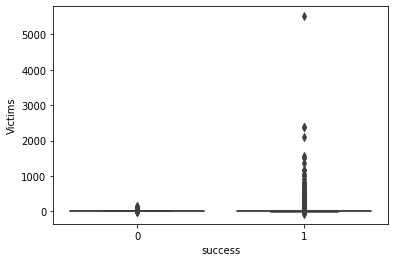

In [17]:
sns.boxplot('success', 'Victims', data=terror)
plt.show()

In [18]:
from bubble_plot.utils import describe_categorical_values

describe_categorical_values(terror)

,0,1,2,3,4
Year,2014: 9%,2015: 8%,2016: 7%,2013: 7%,2017: 6%
Month,5: 9%,7: 9%,8: 9%,10: 9%,6: 8%
Day,15: 4%,1: 3%,4: 3%,16: 3%,10: 3%
Extended,0: 95%,1: 5%,None,None,None
Region,Middle East & North Africa: 28%,South Asia: 25%,South America: 10%,Sub-Saharan Africa: 10%,Western Europe: 9%
vicinity,0: 93%,1: 7%,-9: 0%,None,None
doubtterr,0: 76%,1: 16%,-9: 8%,nan: 0%,None
Attack_Type,Bombing/Explosion: 49%,Armed Assault: 23%,Assassination: 11%,Hostage Taking (Kidnapping): 6%,Facility/Infrastructure Attack: 6%
Target,Civilians: 4%,Unknown: 3%,Soldiers: 2%,Patrol: 2%,Checkpoint: 2%
Summary,nan: 36%,"09/00/2016: Sometime between September 18, 201...",12/01/2016: Assailants detonated explosive dev...,05/29/2016: Security forces discovered and def...,01/11/2016: Assailants set fire to a shop in M...


Summary and Motive are features which might be used at a later checkpoint for NLP but will not be used in analysis for now

Group, while being an interesting feature, might not be useful with 46% being unknown, this can be experimented with.

Most of the attacks are contained in a single day (extended = 0), without a doubt terrorism (doubtterr = 0), Domestic attacks (International = 0), not suicide attacks (suicide = 0) and most are successful (success = 1)

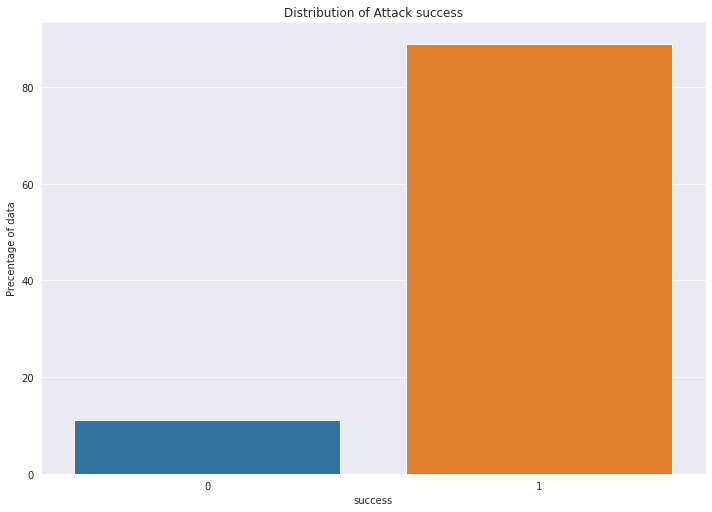

In [19]:
f = plt.figure(figsize=(10, 7))
sns.set_style('darkgrid')
ax = sns.barplot('success', 'success', data=terror, estimator=lambda x: len(x)/len(terror)*100)       
plt.tight_layout()
plt.title('Distribution of Attack success')
plt.xlabel("success")
plt.ylabel('Precentage of data')
plt.show()

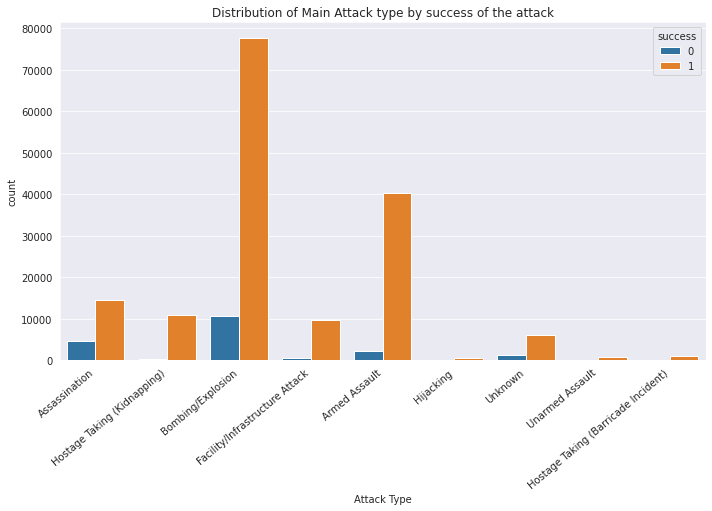

In [20]:
f = plt.figure(figsize=(10, 7))
sns.set_style('darkgrid')
ax = sns.countplot(terror['Attack_Type'], hue=terror['success'], data=terror)       
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Distribution of Main Attack type by success of the attack')
plt.xlabel("Attack Type")
plt.show()

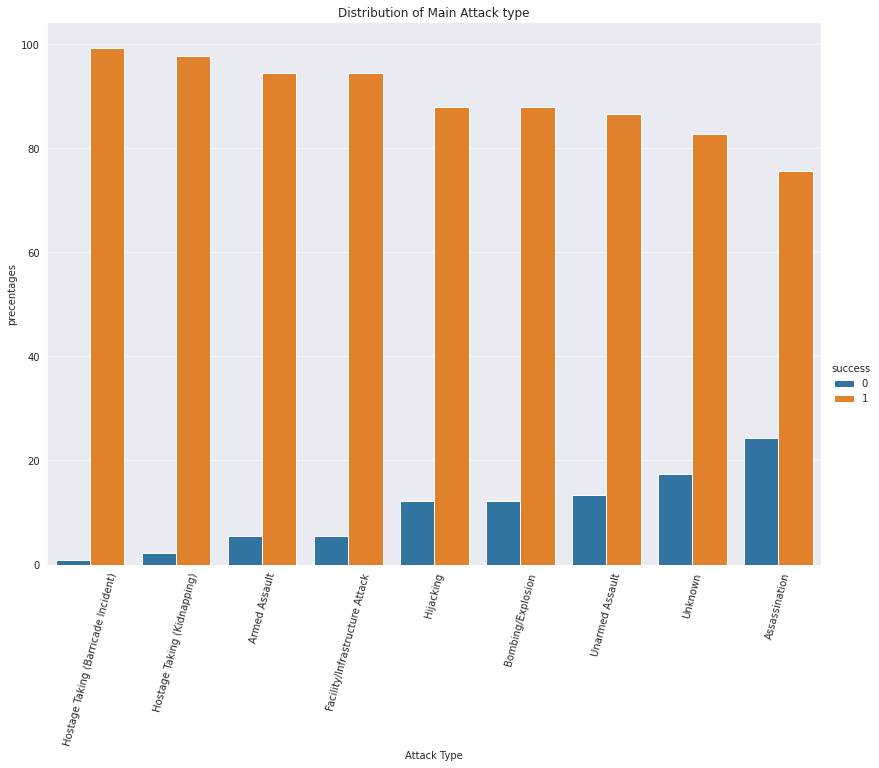

In [21]:
attack_precetanges = terror.groupby(['Attack_Type'])['success'].value_counts(normalize=True).rename('precentages').mul(100).reset_index()
sns.catplot(x='Attack_Type', y='precentages', hue='success', kind='bar', data=attack_precetanges.sort_values('precentages'), height=8.27, aspect=11.7/8.27)
plt.xticks(rotation=75)
plt.title('Distribution of Main Attack type')
plt.xlabel("Attack Type")
plt.show()

Assassination attacks have the highest likelihood to fail, possibly due to the nature of the target, and followed by Unarmed assault, possibly due to the weapon type involved.

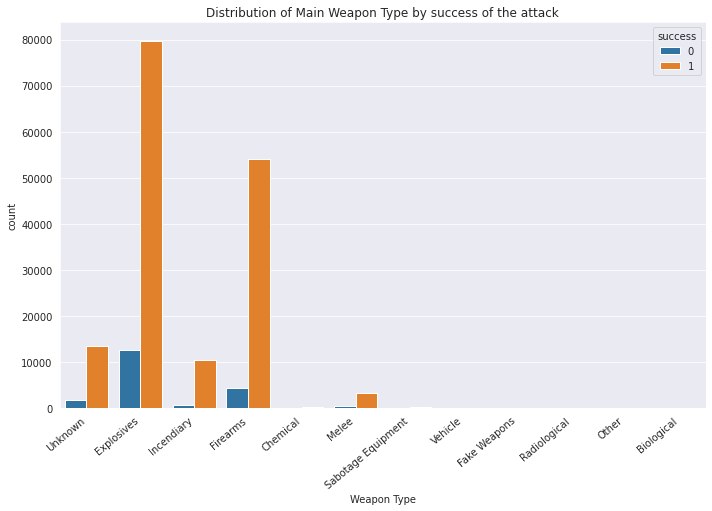

In [22]:
f = plt.figure(figsize=(10, 7))
sns.set_style('darkgrid')
ax = sns.countplot(terror['Weapon_type'], hue=terror['success'], data=terror)       
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Distribution of Main Weapon Type by success of the attack')
plt.xlabel("Weapon Type")
plt.show()

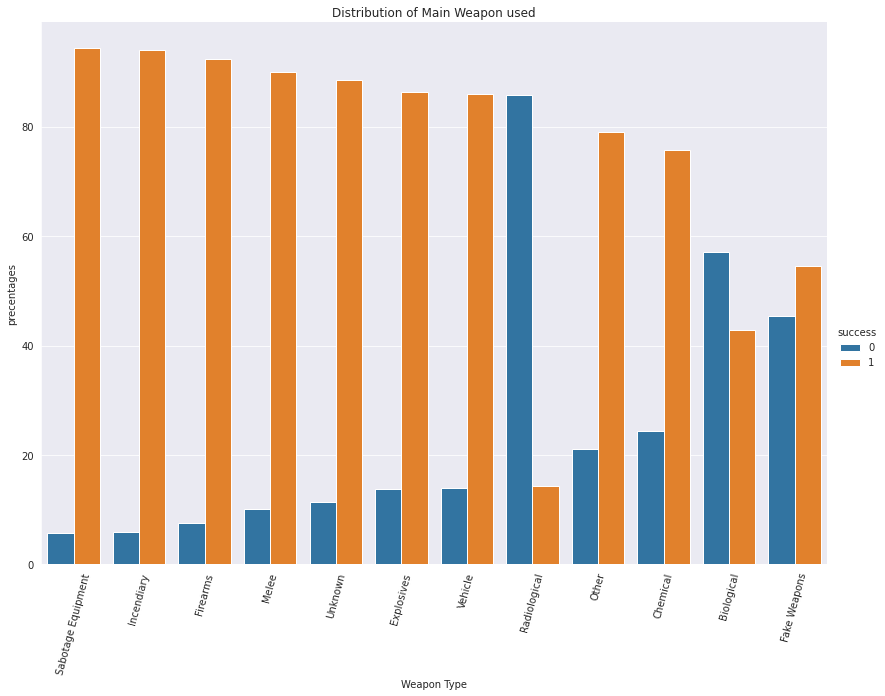

In [23]:
weapon_precetanges = terror.groupby(['Weapon_type'])['success'].value_counts(normalize=True).rename('precentages').mul(100).reset_index()
sns.catplot(x='Weapon_type', y='precentages', hue='success', kind='bar', data=weapon_precetanges.sort_values('precentages'), height=8.27, aspect=11.7/8.27)
plt.xticks(rotation=75)
plt.title('Distribution of Main Weapon used')
plt.xlabel("Weapon Type")
plt.show()

It is clear some Weapon categories have a much weaker correlation to success compared to the general "population" of terror attacks which also somewhat accounts for the attack type, for example, the (relative) low correlation to success for unarmed attacks can be seen here as well as unarmed attacks are defined as attacks involving chemical, biological or radiological weapons which here can be seen to be weapon types with low correlation success

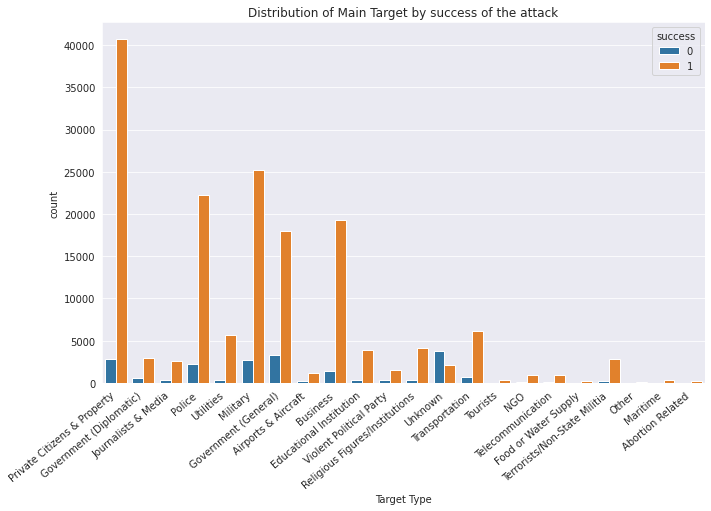

In [24]:
f = plt.figure(figsize=(10, 7))
sns.set_style('darkgrid')
ax = sns.countplot(terror['Target_type'], hue=terror['success'], data=terror)       
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Distribution of Main Target by success of the attack')
plt.xlabel("Target Type")
plt.show()

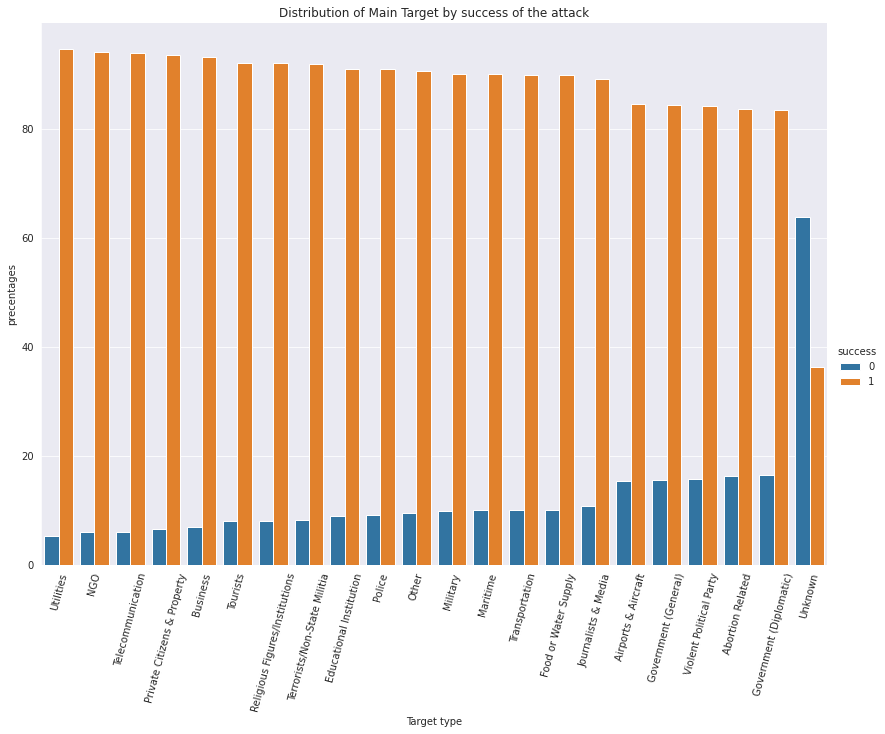

In [25]:
target_precetanges = terror.groupby(['Target_type'])['success'].value_counts(normalize=True).rename('precentages').mul(100).reset_index()
sns.catplot(x='Target_type', y='precentages', hue='success', kind='bar', data=target_precetanges.sort_values('precentages'), height=8.27, aspect=11.7/8.27)
plt.xticks(rotation=75)
plt.title('Distribution of Main Target by success of the attack')
plt.xlabel("Target type")
plt.show()

Unknown targets are the highest representation in the in the failure camp, due to the attack not being successful the intended target is unknown. These rows should probably be removed from the database for the model

In [26]:
print('Regions with Highest Terrorist Attacks:',terror['Region'].value_counts().index[0],', with', 
       str(terror.groupby('Region').success.value_counts().sort_values()[-1]),'successful attacks.')

Regions with Highest Terrorist Attacks: Middle East & North Africa , with 44319 successful attacks.


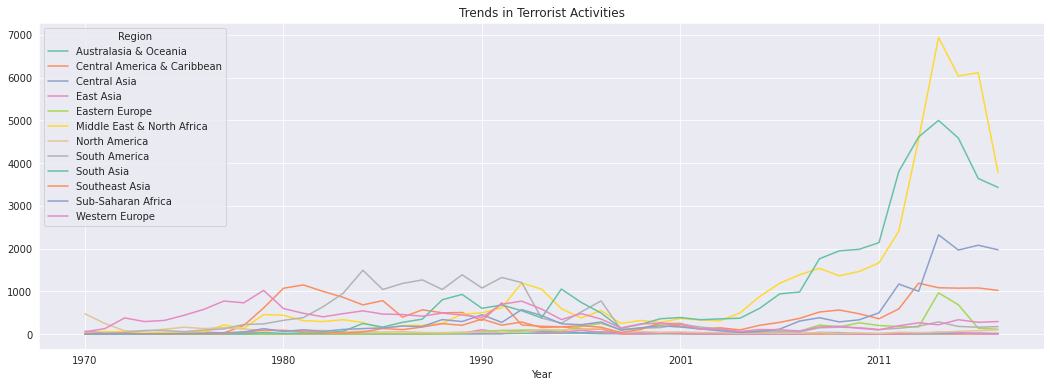

In [27]:
terror_region=pd.crosstab(terror.Year,terror.Region)
terror_region.plot(color=sns.color_palette('Set2',12))
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.title('Trends in Terrorist Activities')
plt.show()

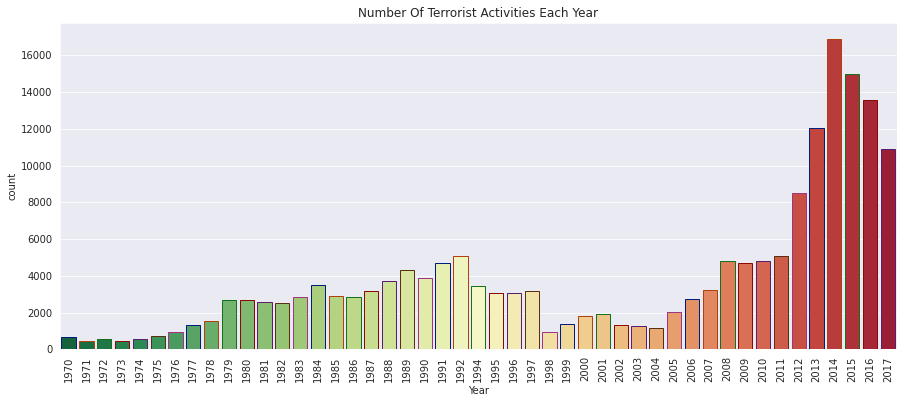

In [28]:
plt.subplots(figsize=(15,6))
sns.countplot('Year',data=terror,palette='RdYlGn_r',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Number Of Terrorist Activities Each Year')
plt.show()

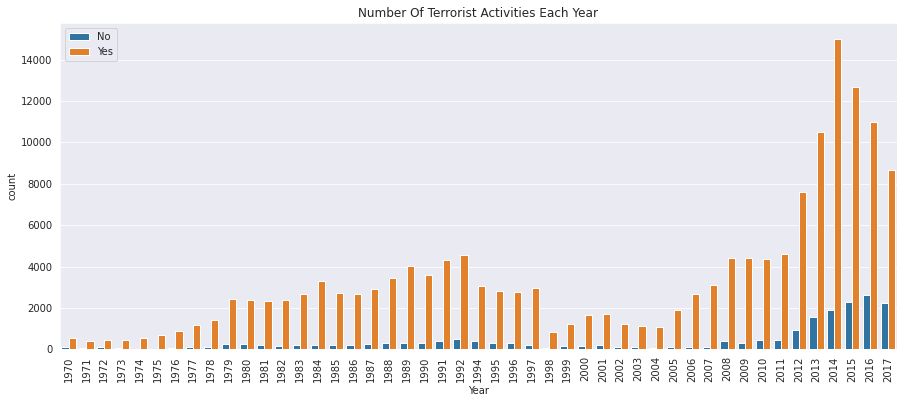

In [29]:
plt.subplots(figsize=(15,6))
sns.countplot('Year',data=terror,hue=terror['success'])
plt.xticks(rotation=90)
plt.title('Number Of Terrorist Activities Each Year')
plt.legend(labels=['No', 'Yes'])
plt.show()

Clearly the number of terrorist activities have gone up sharply after 2000, where as seen in previous result most terror attacks took place in the Middle East & North Africa (South Asia), with about the same proportion between success and failure.

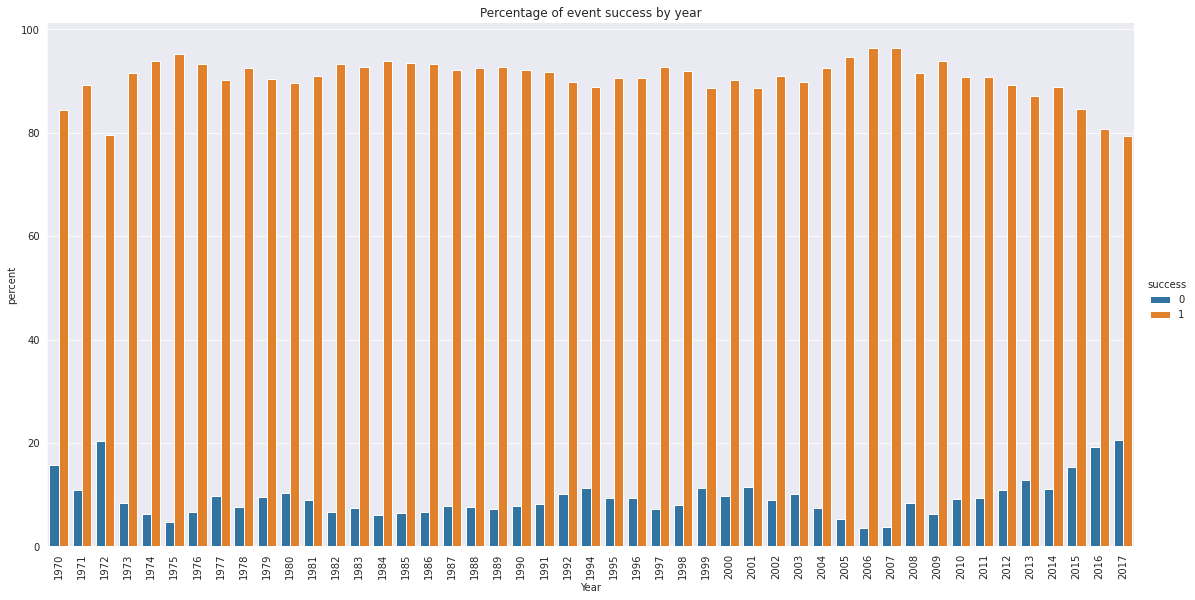

In [30]:
x, y = 'Year', 'success'
terror.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', height=8, aspect=2)
plt.title('Percentage of event success by year')
plt.xticks(rotation=90)
plt.show()

<b> We can see that the success-failure ratio remains 'largely' the same throughout the recent years with a slight trend of increase in failed attacks from 2007.

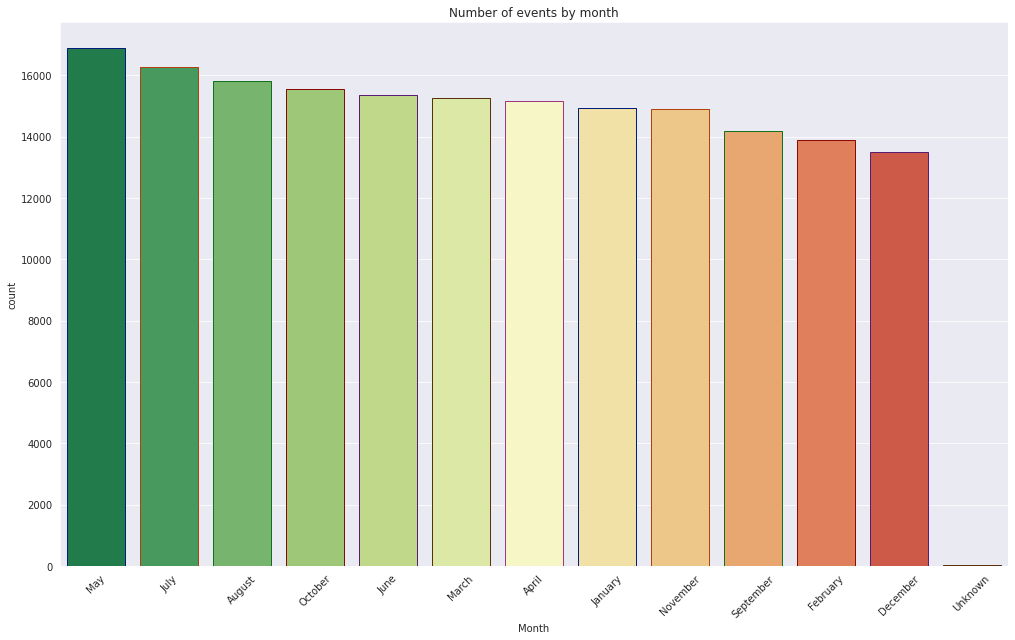

In [31]:
figure, ax = plt.subplots(figsize=(17, 10))
ax = sns.countplot('Month', data=terror, order = terror['Month'].value_counts().index, palette='RdYlGn_r',edgecolor=sns.color_palette('dark',7))
plt.xticks([i for i in range(13)], ['May', 'July', 'August', 'October', 'June', 'March', 'April', 'January', 'November',\
                                    'September', 'February', 'December', 'Unknown'], rotation=45)
plt.title('Number of events by month')
plt.show()

<b> It could be that summer months are more prone to terrorist attacks

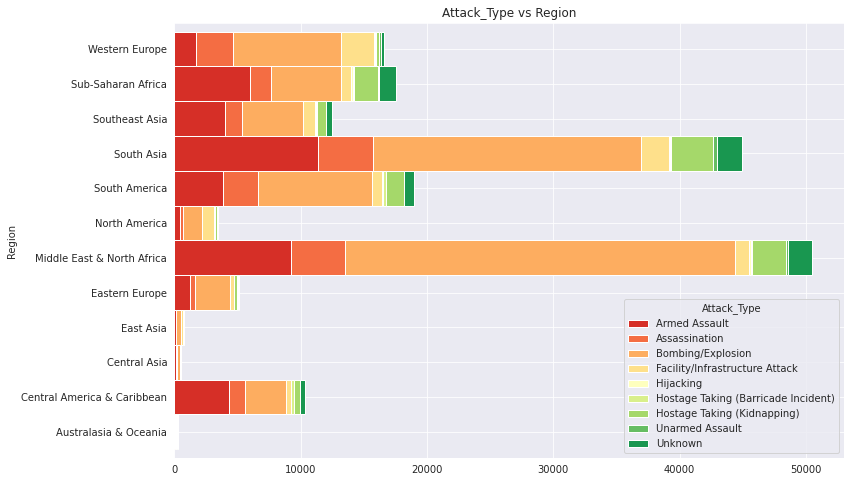

In [32]:
pd.crosstab(terror.Region,terror.Attack_Type).plot.barh(stacked=True,width=1,color=sns.color_palette('RdYlGn',9))
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.title('Attack_Type vs Region')
plt.show()

Clearly Bombing/Explosions and Armed Assault are the most prominent types of attacks, irrespetive of region.

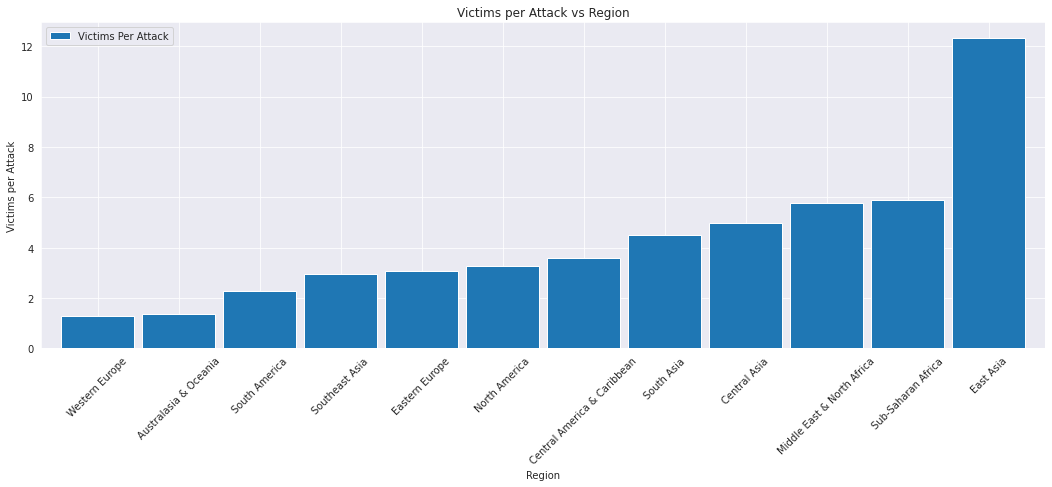

In [33]:
coun_terror=terror['Region'].value_counts().to_frame()
coun_terror.columns=['Attacks']
coun_vict=terror.groupby('Region')['Victims'].sum().to_frame()
norm_vict = pd.DataFrame.from_dict({region: round(coun_vict.loc[region].values[0] / coun_terror.loc[region].values[0], 2) for region in coun_vict.index.values}, orient='index', columns=['Victims Per Attack'])
norm_vict.sort_values(by=['Victims Per Attack']).plot.bar(width=0.9)
plt.xticks(rotation=45)
# coun_terror.merge(coun_vict,left_index=True,right_index=True,how='left').plot.bar(width=0.9)
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.title('Victims per Attack vs Region')
plt.xlabel('Region')
plt.ylabel('Victims per Attack')
plt.show()

For Time Series Analysis let's create a DataFrame that counts all terror attacks per Year and Month.

For time series analysis I will use counts of terrors for both success and failure, to test overall terror activity, as we saw that the proportions are about the same over the years.

Further working may include differentiation between success and failure.

In [34]:
df = terror.groupby('Year').Month.value_counts().to_frame()
df['Terror_counts'] = df['Month']
df = df.drop(['Month'], axis=1)
df.reset_index(inplace=True)

df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)

df = df.sort_values(['Year', 'Month'])

df = df[df['Month'] != 0]

df = df.set_index(['Year', 'Month'])

In [35]:
df

Terror_counts
Year Month               
1970 1                 39
     2                 55
     3                 69
     4                 79
     5                 72
...                   ...
2017 8                968
     9                838
     10               805
     11               804
     12               749

[564 rows x 1 columns]

Using Augmented Dickey-Fuller test let's determine if the series is stationary:

In [36]:
from statsmodels.tsa.stattools import adfuller
X = df['Terror_counts'].values
results = adfuller(X)
print('p-value: ' + str(results[1]))

p-value: 0.4172900231723409


We see that p-value is ~0.4 which is higher than 0.05, meaning we fail to reject the null hypothesis, thus according to Augmented Dickey-Fuller test we can say that the series in Non-stationary, which make sense according to Trends in Terror Activities plot.

Let's calculate Rolling Moving Average over window of 12 month:

In [37]:
df2 = df.rolling(window=12).mean()

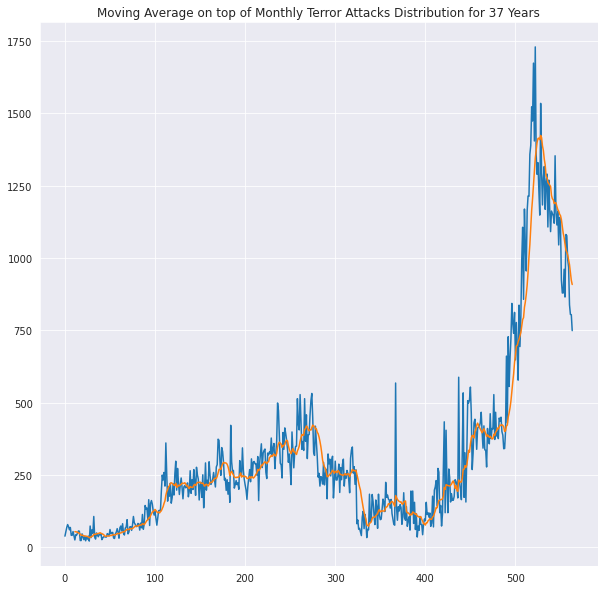

In [38]:
index_num = np.arange(564)
plt.figure(figsize=(10,10))
plt.plot(index_num, df['Terror_counts'])
plt.plot(index_num, df2['Terror_counts'])
plt.title('Moving Average on top of Monthly Terror Attacks Distribution for 37 Years');

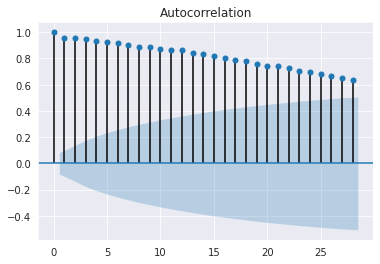

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Terror_counts']);

According to Autocorrelation graph we can't see seasonality.

However, as seen from previous plots, The number of terror activities has gone up sharply from 2000, so let's try to find seasonality in terror activities between 1970-2000, and between 2000-2017.

**Looking for seasonality between 1970-2000**

In [40]:
df3 = df[:348]
df3

Terror_counts
Year Month               
1970 1                 39
     2                 55
     3                 69
     4                 79
     5                 72
...                   ...
1999 8                114
     9                 79
     10               164
     11               141
     12                66

[348 rows x 1 columns]

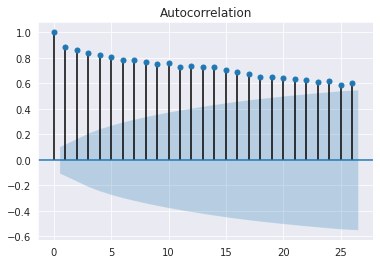

In [41]:
plot_acf(df3['Terror_counts']);

**Looking for seasonality between 2000-2017**

In [42]:
df4 = df[348:]
df4

Terror_counts
Year Month               
2000 1                184
     2                112
     3                 96
     4                 98
     5                131
...                   ...
2017 8                968
     9                838
     10               805
     11               804
     12               749

[216 rows x 1 columns]

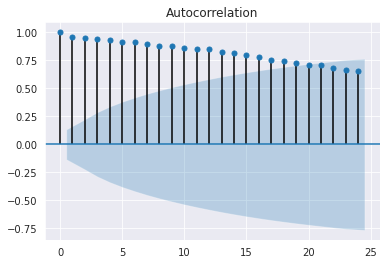

In [43]:
plot_acf(df4['Terror_counts']);

For both plots we can't see seasonality, even though the split looks somehow more seasonal compare to first plot.

Maybe those time series are too big for seasonality search, so let's try to narrow the time series, for say 10 years:

**Looking for seasonality between 1970-1980**

In [44]:
df5 = df[:120]
df5

Terror_counts
Year Month               
1970 1                 39
     2                 55
     3                 69
     4                 79
     5                 72
...                   ...
1979 8                210
     9                177
     10               222
     11               153
     12               172

[120 rows x 1 columns]

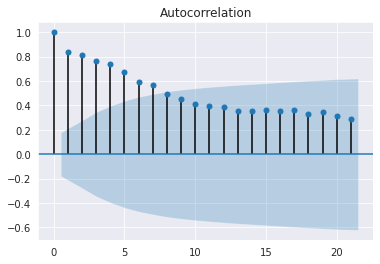

In [45]:
plot_acf(df5['Terror_counts']);

That plot looks pretty much the same to the other plots but on a smaller scale, yet we still can't see seasonality.

Let's try to convert the data frame, and count terror activities per year, instead of terror activities per year and month.

**Some analysis**

In [46]:
terror_per_year = []
for i in range(0,564,12):
    terror_per_year.append(df[i:i+12].sum())

In [47]:
by_year_df = pd.DataFrame(terror_per_year)
len_by_year = len(by_year_df)

In [48]:
display(by_year_df)

,Terror_counts
0,650
1,471
2,567
3,472
4,579
5,739
6,921
7,1314
8,1524
9,2659


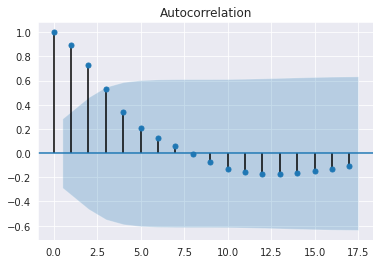

In [49]:
plot_acf(by_year_df['Terror_counts']);

This graph is more interesting.

Still, we can't see seasonality, yet we can try to think of predicting some kind of pattern.

I'm not sure about it, but maybe we can use this graph in order to build prediction.  Maybe we can assume some kind of symmetry, such that this Autocorrelation graph will reach its next local max point in 5 more units over x-axis, and then behave the same for the next 22.5 unit over x-axis.

Meaning, maybe we can predict seasonality of 22.5 years (about 2 years).

**Building Autocorrelation Model for by_year_df**

Preparing the data:

In [50]:
def auto_correlation_data_prep(k):
    
    terror_per_year = []
    for i in range(0,564,12):
        terror_per_year.append(df[i:i+12].sum())
    
    by_year_new_df = pd.DataFrame(terror_per_year)
    len_by_year = len(by_year_new_df)
    
    for i in range(1, k+1):
        by_year_new_df[f'shift{i}'] = by_year_new_df['Terror_counts'].shift(periods=i)
    return by_year_new_df

total_lag = 15
tmp = auto_correlation_data_prep(total_lag)
shifted_terror_df = tmp[total_lag:]
shifted_terror_df.head()

,Terror_counts,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12,shift13,shift14,shift15
15,2915,3495.0,2870.0,2543.0,2586.0,2662.0,2659.0,1524.0,1314.0,921.0,739.0,579.0,472.0,567.0,471.0,650.0
16,2859,2915.0,3495.0,2870.0,2543.0,2586.0,2662.0,2659.0,1524.0,1314.0,921.0,739.0,579.0,472.0,567.0,471.0
17,3183,2859.0,2915.0,3495.0,2870.0,2543.0,2586.0,2662.0,2659.0,1524.0,1314.0,921.0,739.0,579.0,472.0,567.0
18,3721,3183.0,2859.0,2915.0,3495.0,2870.0,2543.0,2586.0,2662.0,2659.0,1524.0,1314.0,921.0,739.0,579.0,472.0
19,4324,3721.0,3183.0,2859.0,2915.0,3495.0,2870.0,2543.0,2586.0,2662.0,2659.0,1524.0,1314.0,921.0,739.0,579.0


For this case we don't have enough rows to build big enough model.  Still let's try to get some initial results.
I don't know exactly how how to choose the best k for this problem, so I will choose random k=15, as it seems to give enough data for avoiding underfitting and overfitting.

Splitting the data half way:

In [51]:
train_index = int(len(shifted_terror_df)*0.5)

In [52]:
D_train = shifted_terror_df[:train_index]
D_test = shifted_terror_df[train_index:]

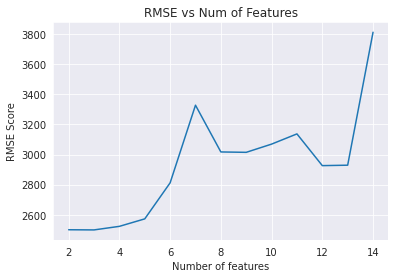

In [53]:
results =[]
for lag in range(2, total_lag):
    X_train = D_train.values[:, 1:lag]
    y_train = D_train['Terror_counts']
    X_test = D_test.values[:, 1:lag]
    y_test = D_test['Terror_counts']
    
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    results.append([lag, np.sqrt(mean_squared_error(y_test, y_predict))])

results = np.asarray(results)

plt.plot(results[:, 0], results[:, 1])
plt.xlabel('Number of features')
plt.ylabel('RMSE Score')
plt.title('RMSE vs Num of Features');

According to the plot we get the lowest RMSE scores for k=2, however k=2 is too small.
We see that there is a significant increase in RMSE score starting from k=5, so we'll choose it is the optimal k for the model.

Let's print coefficients and intercept:

In [54]:
optimal_k = 5
X_train = D_train.values[:, 1:optimal_k]
y_train = D_train['Terror_counts']
X_test = D_test.values[:, 1:optimal_k]
y_test = D_test['Terror_counts']

clf5 = LinearRegression()
clf5.fit(X_train, y_train)
y5_predict = clf5.predict(X_test)

coeff = clf5.coef_
intercept = clf5.intercept_
rmse = np.sqrt(mean_squared_error(y_test, y5_predict))

print('RMSE score: ' + str(rmse))
print('Coefficients: ' + str(coeff[:]))
print('Intercept: ' + str(intercept))

RMSE score: 2572.267384251132
Coefficients: [ 0.79349538 -0.13697415  0.26967931 -0.25371719]
Intercept: 979.1789170834627


The RMSE score is too big.

For this model we used time space of 1 year.

Let's try to build Autoregression model for the previous dataframe where we took time space of 1 month

Creating the data:

In [55]:
def auto_correlation_data_prep(k):
    for i in range(1, k+1):
        df[f'shift{i}'] = df['Terror_counts'].shift(periods=i)
    return df

total_lag = 30
tmp = auto_correlation_data_prep(total_lag)
by_month_df = tmp[total_lag:]
by_month_df.head()

Terror_counts  shift1  shift2  shift3  shift4  shift5  shift6  \
Year Month                                                                  
1972 7                 61    34.0    74.0    22.0    39.0    29.0    37.0   
     8                 49    61.0    34.0    74.0    22.0    39.0    29.0   
     9                107    49.0    61.0    34.0    74.0    22.0    39.0   
     10                36   107.0    49.0    61.0    34.0    74.0    22.0   
     11                29    36.0   107.0    49.0    61.0    34.0    74.0   

            shift7  shift8  shift9  ...  shift21  shift22  shift23  shift24  \
Year Month                          ...                                       
1972 7        23.0    39.0    27.0  ...     55.0     42.0     42.0     69.0   
     8        37.0    23.0    39.0  ...     41.0     55.0     42.0     42.0   
     9        29.0    37.0    23.0  ...     26.0     41.0     55.0     42.0   
     10       39.0    29.0    37.0  ...     44.0     26.0     41.0     55.0   
     11       22.0    39.0    29.0  ...     43.0     44.0     26.0     41.0   

            shift25  shift26  shift27  shift28  shift29  shift30  
Year Month                                                        
1972 7         61.0     72.0     79.0     69.0     55.0     39.0  
     8         69.0     61.0     72.0     79.0     69.0     55.0  
     9         42.0     69.0     61.0     72.0     79.0     69.0  
     10        42.0     42.0     69.0     61.0     72.0     79.0  
     11        55.0     42.0     42.0     69.0     61.0     72.0  

[5 rows x 31 columns]

Splitting half way:

In [56]:
D_train = by_month_df[:train_index]
D_test = by_month_df[train_index:]

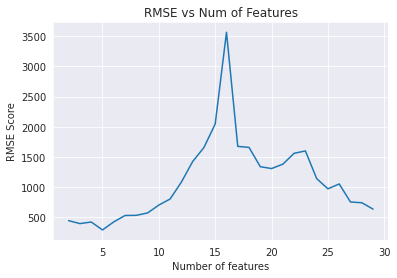

In [57]:
results =[]
for lag in range(2, total_lag):
    X_train = D_train.values[:, 1:lag]
    y_train = D_train['Terror_counts']
    X_test = D_test.values[:, 1:lag]
    y_test = D_test['Terror_counts']
    
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    results.append([lag, np.sqrt(mean_squared_error(y_test, y_predict))])

results = np.asarray(results)

plt.plot(results[:, 0], results[:, 1])
plt.xlabel('Number of features')
plt.ylabel('RMSE Score')
plt.title('RMSE vs Num of Features');

For this model we get the same result as in the model by year, k=5, with much lower RMSE score, so we may consider using the model by month and discrad the model by year, or to think of a different approacn by year.

Let's print the coefficients and intercept:

In [58]:
optimal_k = 5
X_train = D_train.values[:, 1:optimal_k]
y_train = D_train['Terror_counts']
X_test = D_test.values[:, 1:optimal_k]
y_test = D_test['Terror_counts']

clf5 = LinearRegression()
clf5.fit(X_train, y_train)
y5_predict = clf5.predict(X_test)

coeff = clf5.coef_
intercept = clf5.intercept_
rmse = np.sqrt(mean_squared_error(y_test, y5_predict))

print('RMSE score: ' + str(rmse))
print('Coefficients: ' + str(coeff[:]))
print('Intercept: ' + str(intercept))

RMSE score: 287.60046123460995
Coefficients: [ 0.04339884  0.08247496 -0.02030795  0.26844552]
Intercept: 27.583660072622493


## Prediction Terror Attack Success

We will only use features which can possibly be estimated using intelligence gathering on a suspected terror attack ahead of the attack actually taking place. Using a feature such as Victims will not only be too indicative of the attack success but is also impossible to know ahead of time  

<b>Preprocessing

In [59]:
print(f'Number of samples in dataset before dropping rows with unknown values: {terror.shape[0]}')

Number of samples in dataset before dropping rows with unknown values: 181691


In [60]:
terror.drop(terror.loc[terror['Month'] == '0'].index, axis=0, inplace=True)
terror.drop(terror.loc[terror['Day'] == '0'].index, axis=0, inplace=True)

terror.drop(terror.loc[terror['vicinity'] == '-9'].index, axis=0, inplace=True)
terror.drop(terror.loc[terror['International'] == '-9'].index, axis=0, inplace=True)

terror.drop(terror.loc[terror['Attack_Type'] == 'Unknown'].index, axis=0, inplace=True)
terror.drop(terror.loc[terror['Target_type'] == 'Unknown'].index, axis=0, inplace=True)
terror.drop(terror.loc[terror['Weapon_type'] == 'Unknown'].index, axis=0, inplace=True)

In [61]:
print(f'Number of samples in dataset after dropping rows with unknown values: {terror.shape[0]}')

Number of samples in dataset after dropping rows with unknown values: 159857


<b>Train/Test split stratify by target parameter -</b> During gridsearch we'll use cross validation so validation set isn't required

In [62]:
features = ['Month', 'Day', 'Extended', 'vicinity' ,'Attack_Type', 'Weapon_type',\
            'Target_type', 'International', 'suicide']
target = 'success'

X = terror.loc[:, features]
y = terror[target]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=42, stratify=terror[target])

print(f'Train set size: {round(X_train.shape[0]/len(terror),2)*100}%\n\
Test set size: {round(X_test.shape[0]/len(terror),2)*100}%')

set(X_train.index) & set(X_test.index)

Train set size: 80.0%
Test set size: 20.0%


set()

<b>Categorical values with less than 10% (adjustable) in each category will be combined into the 'Other' category

In [63]:
threshold = 0.01  
for feat in ['Target_type', 'Weapon_type']:
    temp = (X_train.loc[:, feat].value_counts(normalize=True) > threshold)
    other_list = temp.loc[temp == False].index.tolist()
    
    X_train.loc[:, feat] = X_train.loc[:, feat].apply(lambda x: 'Other' if x in other_list else x)
    X_test.loc[:, feat] = X_test.loc[:, feat].apply(lambda x: 'Other' if x in other_list else x)

<b>Categorical features need to be encoded with one-hot-encoding or labeling, I tested both methods and decided to go with one-hot-encoding to better see correlation to specific categories

In [64]:
word_features = ['Attack_Type', 'Target_type', 'Weapon_type']
X_train = pd.get_dummies(X_train,columns=word_features)
X_test = pd.get_dummies(X_test,columns=word_features)

y_train, y_test = y_train.astype(int), y_test.astype(int)

In [65]:
X_train.head()

,Month,Day,Extended,vicinity,International,suicide,Attack_Type_Armed Assault,Attack_Type_Assassination,Attack_Type_Bombing/Explosion,Attack_Type_Facility/Infrastructure Attack,...,Target_type_Religious Figures/Institutions,Target_type_Terrorists/Non-State Militia,Target_type_Transportation,Target_type_Utilities,Target_type_Violent Political Party,Weapon_type_Explosives,Weapon_type_Firearms,Weapon_type_Incendiary,Weapon_type_Melee,Weapon_type_Other
5675,12,22,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
63942,11,13,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
123090,11,6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
101437,5,6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
81963,12,3,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [66]:
from bubble_plot.utils import get_most_correlated_variables, plot_correlation_matrix

data_corr = X_train.copy()
data_corr['Sucess'] = y_train.astype(int).copy()

corr = data_corr.corr()

most_correlated_variables = get_most_correlated_variables(corr, num_pairs=10)
most_correlated_variables

,var_1,var_2,value
0,Weapon_type_Melee,Attack_Type_Unarmed Assault,0.295094
1,Attack_Type_Bombing/Explosion,Attack_Type_Assassination,-0.360231
2,Weapon_type_Other,Attack_Type_Unarmed Assault,0.428431
3,Weapon_type_Explosives,Attack_Type_Armed Assault,-0.593715
4,Attack_Type_Bombing/Explosion,Attack_Type_Armed Assault,-0.614164
5,Weapon_type_Firearms,Attack_Type_Armed Assault,0.625267
6,Weapon_type_Firearms,Attack_Type_Bombing/Explosion,-0.754981
7,Weapon_type_Incendiary,Attack_Type_Facility/Infrastructure Attack,0.781214
8,Weapon_type_Firearms,Weapon_type_Explosives,-0.820231
9,Weapon_type_Explosives,Attack_Type_Bombing/Explosion,0.918342


As can be expected some strong correlations can be seen between the type of the attack and the type of weapon used

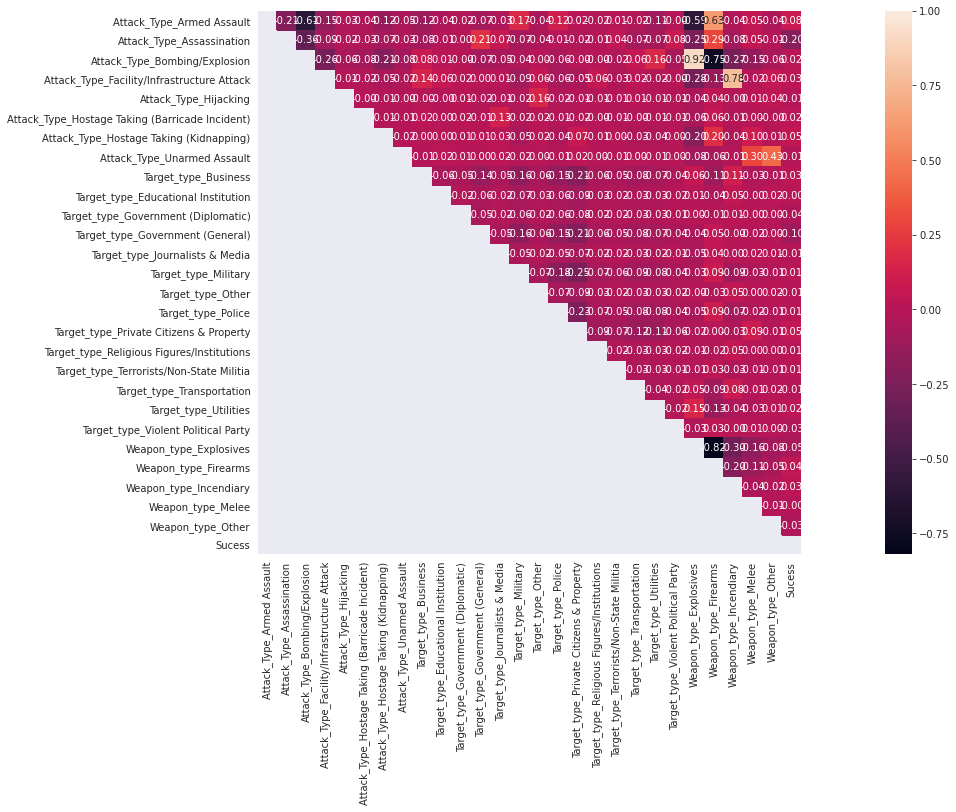

In [67]:
plt.figure(figsize=(30,10))
mask = np.tril(np.ones_like(corr, dtype=np.bool))
sns.heatmap(data_corr.corr(), annot=True, fmt=".2f", mask = mask, square = True)
plt.show()

For the baseline model the aim was to achieve a better result than a naive classifier which always predicts the majority class, which in our case is the attack being successful (EDA shows the ratio to be 89% successful attacks vs 11% failed attacks).

Additionally we can strive to achieve good recall for the purpose of correctly predicting potentially successful terror attacks. We are less concerned with misclassifying unsuccessful terror attacks as successful now and then.

<b>DecisionTree

array([[  594,  2301],
       [ 1286, 27791]])

Accuracy Test: 0.888
Accuracy Train: 0.936
              precision    recall  f1-score   support

           0       0.32      0.21      0.25      2895
           1       0.92      0.96      0.94     29077

    accuracy                           0.89     31972
   macro avg       0.62      0.58      0.59     31972
weighted avg       0.87      0.89      0.88     31972



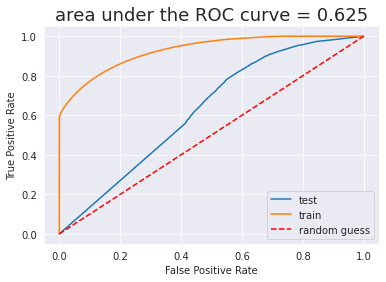

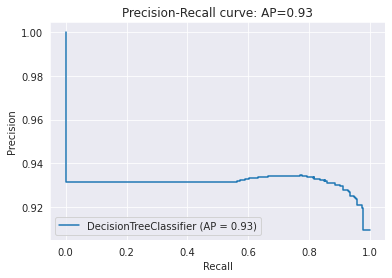

In [68]:
model = DecisionTreeClassifier() 
model.fit(X_train, y_train)

get_model_results(model, X_train, X_test, y_train, y_test)

The baseline decision tree model can make decent predictions when predicting a successful attack because successful attacks are the majority class but it does seem to overfit the training data and we can try to improve on the amount of False Negatives the model predicts or improve the precision on the zero class (if failure is positive than high precision means low false positive - predicting attack failure when in fact its going to success)

Best Criterion: entropy
Best max_features: None
Best max_depth: 4
Best Paramaters score: 0.91


array([[  448,  2447],
       [  224, 28853]])

Accuracy Test: 0.916
Accuracy Train: 0.914
              precision    recall  f1-score   support

           0       0.67      0.15      0.25      2895
           1       0.92      0.99      0.96     29077

    accuracy                           0.92     31972
   macro avg       0.79      0.57      0.60     31972
weighted avg       0.90      0.92      0.89     31972



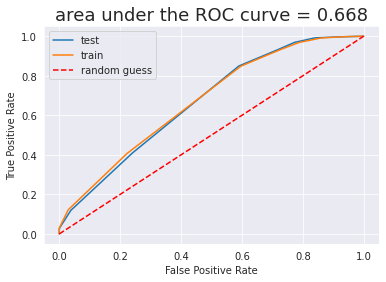

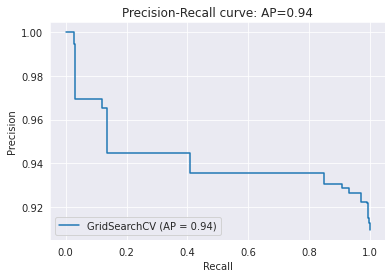

In [69]:
parameters = {'criterion': ('gini', 'entropy'), 'max_depth': [4,8,12, None], 'max_features': ['auto', None]}
model = GridSearchCV(DecisionTreeClassifier(), parameters, scoring='f1_micro', cv=5)
model.fit(X_train, y_train)

# View The Best Parameters
print('Best Criterion:', model.best_estimator_.get_params()['criterion'])
print('Best max_features:', model.best_estimator_.get_params()['max_features'])
print('Best max_depth:', model.best_estimator_.get_params()['max_depth'])
print(f'Best Paramaters score: {round(model.best_score_, 2)}')

get_model_results(model, X_train, X_test, y_train, y_test)

This decision tree is an improvement on precision and f1 score for prediction failure as well as recall improvement for predicting success and overall it doesn't overfit the training set

array([[  493,  2402],
       [  689, 28388]])

Accuracy Test: 0.903
Accuracy Train: 0.936
              precision    recall  f1-score   support

           0       0.42      0.17      0.24      2895
           1       0.92      0.98      0.95     29077

    accuracy                           0.90     31972
   macro avg       0.67      0.57      0.60     31972
weighted avg       0.88      0.90      0.88     31972



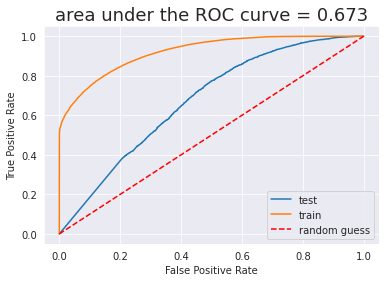

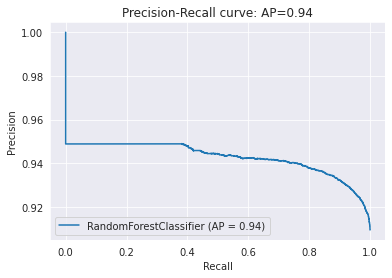

In [70]:
model = RandomForestClassifier() 
model.fit(X_train, y_train)

get_model_results(model, X_train, X_test, y_train, y_test)

Our first RandomForest model is actually a step down compared to the previous optimized Decision Tree in all of the metrics and is back to overfitting

From repeated use of GridSearchCV with various parameters and the following model was achieved

array([[  389,  2506],
       [  164, 28913]])

Accuracy Test: 0.916
Accuracy Train: 0.918
              precision    recall  f1-score   support

           0       0.70      0.13      0.23      2895
           1       0.92      0.99      0.96     29077

    accuracy                           0.92     31972
   macro avg       0.81      0.56      0.59     31972
weighted avg       0.90      0.92      0.89     31972



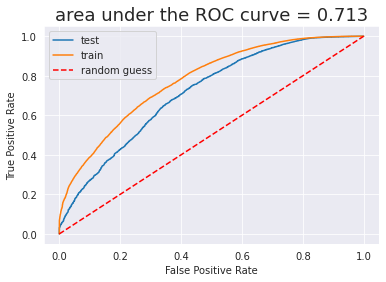

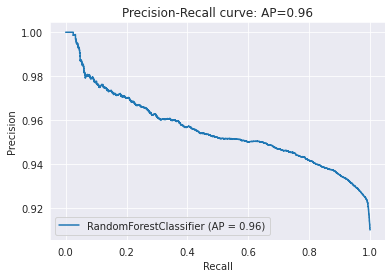

In [88]:
model = RandomForestClassifier(n_estimators=150, max_depth=12) 
model.fit(X_train, y_train)

get_model_results(model, X_train, X_test, y_train, y_test)

In [90]:
x = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0])

features_lst = ['extended', 'vicinity', 'international', 'suicide', 'Assassination', 'Bombing/Explosion',\
                    'Hostage Taking (Kidnapping)', 'Armed Assault', 'Facility/Infrastructure Attack']

exp = LimeTabularExplainer(x.reshape(1, -1), feature_names=features_lst, discretize_continuous=True,\
                               class_names=['Failure', 'Success'], feature_selection='lasso_path')
exp.explain_instance(x, model.predict_proba).show_in_notebook()

The scoring method which achieved the best result is recall_macro, and even when using it, the optimized random forest is only a slight improvement on the optimized decision tree model

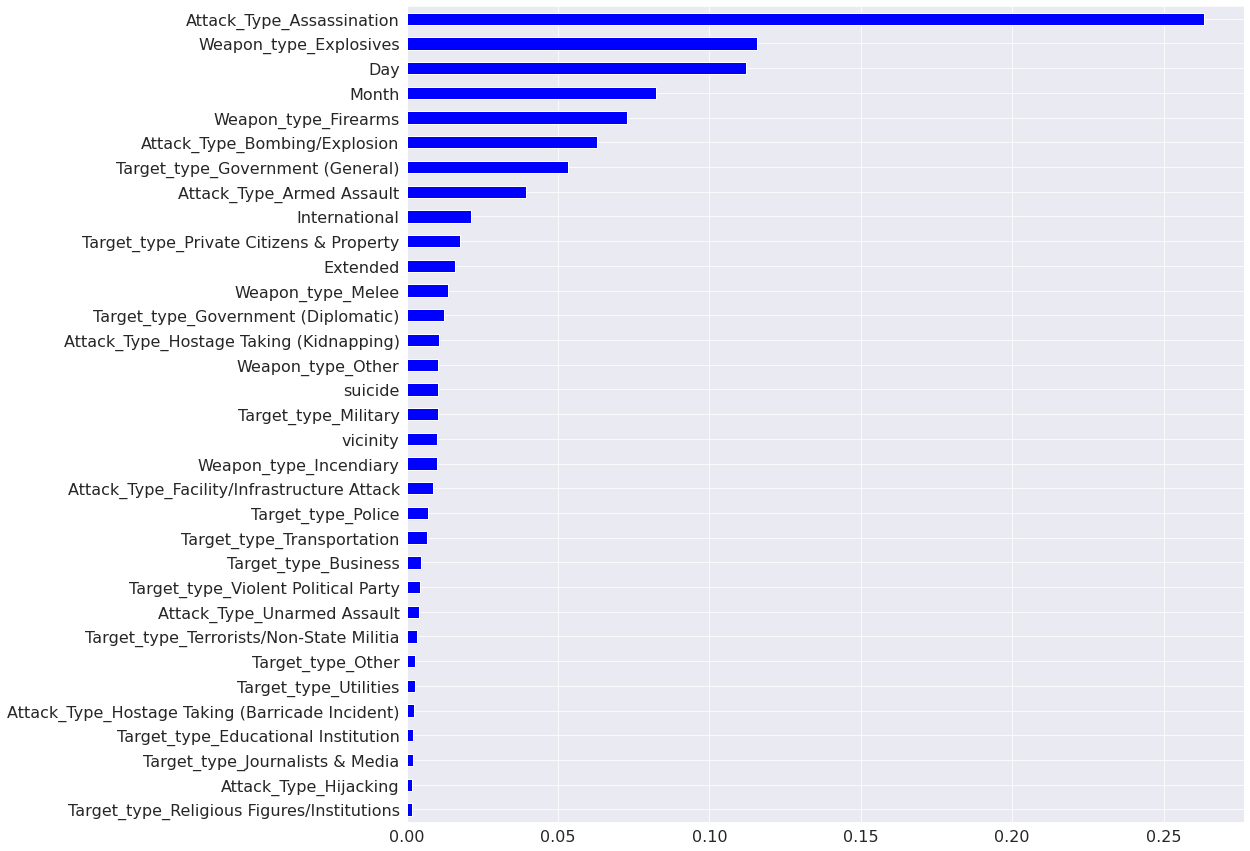

In [72]:
feature_importance = pd.Series(index=X_train.columns, data=model.feature_importances_)
feature_importance = feature_importance.sort_values()
plt.figure(figsize=(15,15))
feature_importance.plot.barh(fontsize=16,color='b' )
plt.show()

Thanks to the RandomForest and the one-hot-encoding, some specific categories can be seen to have a strong affect on the decision of the model and we might consider dropping low importance features

<b>Decision Tree and RandomForest with Label Encoding

In [73]:
features = ['Month', 'Day', 'Extended', 'vicinity' ,'Attack_Type', 'Weapon_type',\
            'Target_type', 'International', 'suicide']
target = 'success'

X = terror.loc[:, features]
y = terror[target]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=42, stratify=terror[target])

print(f'Train set size: {round(X_train.shape[0]/len(terror),2)*100}%\n\
Test set size: {round(X_test.shape[0]/len(terror),2)*100}%')

set(X_train.index) & set(X_test.index)

Train set size: 80.0%
Test set size: 20.0%


set()

In [74]:
threshold = 0.01  
for feat in ['Target_type', 'Weapon_type']:
    temp = (X_train.loc[:, feat].value_counts(normalize=True) > threshold)
    other_list = temp.loc[temp == False].index.tolist()
    
    X_train.loc[:, feat] = X_train.loc[:, feat].apply(lambda x: 'Other' if x in other_list else x)
    X_test.loc[:, feat] = X_test.loc[:, feat].apply(lambda x: 'Other' if x in other_list else x)

In [75]:
# Label Encoding

from sklearn.preprocessing import LabelEncoder

word_features = ['Attack_Type', 'Target_type', 'Weapon_type']
for feat in word_features:
    le = LabelEncoder()
    X_train[f'{feat}_label'] = le.fit_transform(X_train[feat])
    X_test[f'{feat}_label'] = le.transform(X_test[feat])
    
X_train, X_test = X_train.drop(word_features, axis=1).astype(int), X_test.drop(word_features, axis=1).astype(int)
y_train, y_test = y_train.astype(int), y_test.astype(int)

array([[  592,  2303],
       [ 1277, 27800]])

Accuracy Test: 0.888
Accuracy Train: 0.936
              precision    recall  f1-score   support

           0       0.32      0.20      0.25      2895
           1       0.92      0.96      0.94     29077

    accuracy                           0.89     31972
   macro avg       0.62      0.58      0.59     31972
weighted avg       0.87      0.89      0.88     31972



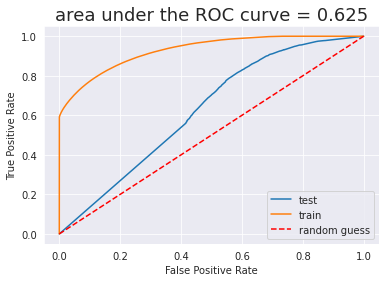

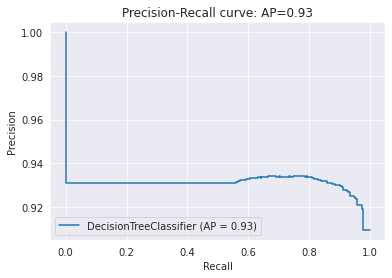

In [76]:
model = DecisionTreeClassifier() 
model.fit(X_train, y_train)

get_model_results(model, X_train, X_test, y_train, y_test)

Best Criterion: gini
Best max_features: None
Best max_depth: 4
Best Paramaters score: 0.91


array([[  448,  2447],
       [  224, 28853]])

Accuracy Test: 0.916
Accuracy Train: 0.914
              precision    recall  f1-score   support

           0       0.67      0.15      0.25      2895
           1       0.92      0.99      0.96     29077

    accuracy                           0.92     31972
   macro avg       0.79      0.57      0.60     31972
weighted avg       0.90      0.92      0.89     31972



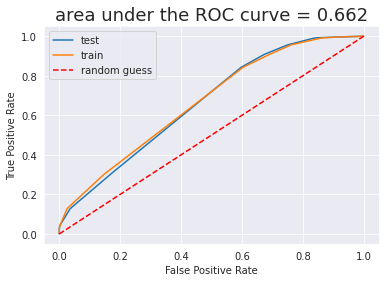

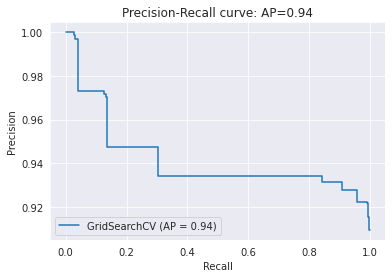

In [77]:
parameters = {'criterion': ('gini', 'entropy'), 'max_depth': [4,8,12, None], 'max_features': ['auto', None]}
model = GridSearchCV(DecisionTreeClassifier(), parameters, scoring='f1_micro', cv=5)
model.fit(X_train, y_train)

# View The Best Parameters
print('Best Criterion:', model.best_estimator_.get_params()['criterion'])
print('Best max_features:', model.best_estimator_.get_params()['max_features'])
print('Best max_depth:', model.best_estimator_.get_params()['max_depth'])
print(f'Best Paramaters score: {round(model.best_score_, 2)}')

get_model_results(model, X_train, X_test, y_train, y_test)

array([[  469,  2426],
       [  631, 28446]])

Accuracy Test: 0.904
Accuracy Train: 0.936
              precision    recall  f1-score   support

           0       0.43      0.16      0.23      2895
           1       0.92      0.98      0.95     29077

    accuracy                           0.90     31972
   macro avg       0.67      0.57      0.59     31972
weighted avg       0.88      0.90      0.88     31972



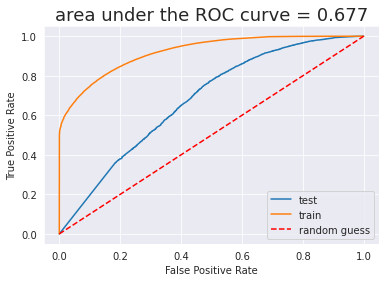

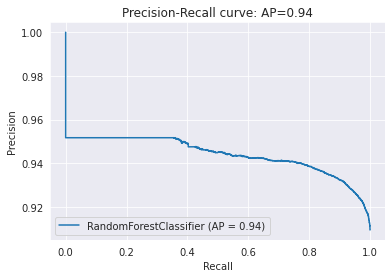

In [83]:
model = RandomForestClassifier() 
model.fit(X_train, y_train)

get_model_results(model, X_train, X_test, y_train, y_test)

array([[  390,  2505],
       [  164, 28913]])

Accuracy Test: 0.917
Accuracy Train: 0.918
              precision    recall  f1-score   support

           0       0.70      0.13      0.23      2895
           1       0.92      0.99      0.96     29077

    accuracy                           0.92     31972
   macro avg       0.81      0.56      0.59     31972
weighted avg       0.90      0.92      0.89     31972



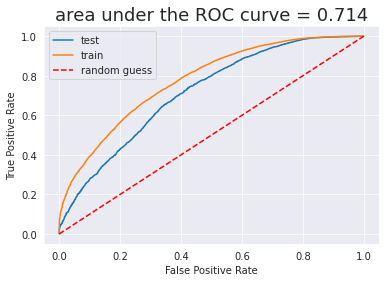

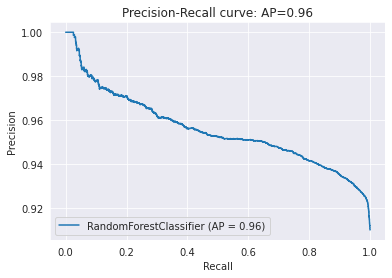

In [79]:
model = RandomForestClassifier(n_estimators=150, max_depth=12) 
model.fit(X_train, y_train)

get_model_results(model, X_train, X_test, y_train, y_test)

Label Encoder Optimized RandomForest model presents very slightly improved results but more importantly it allows us to observe general feature important without considering specific categories in the features so we can better choose features that can be removed

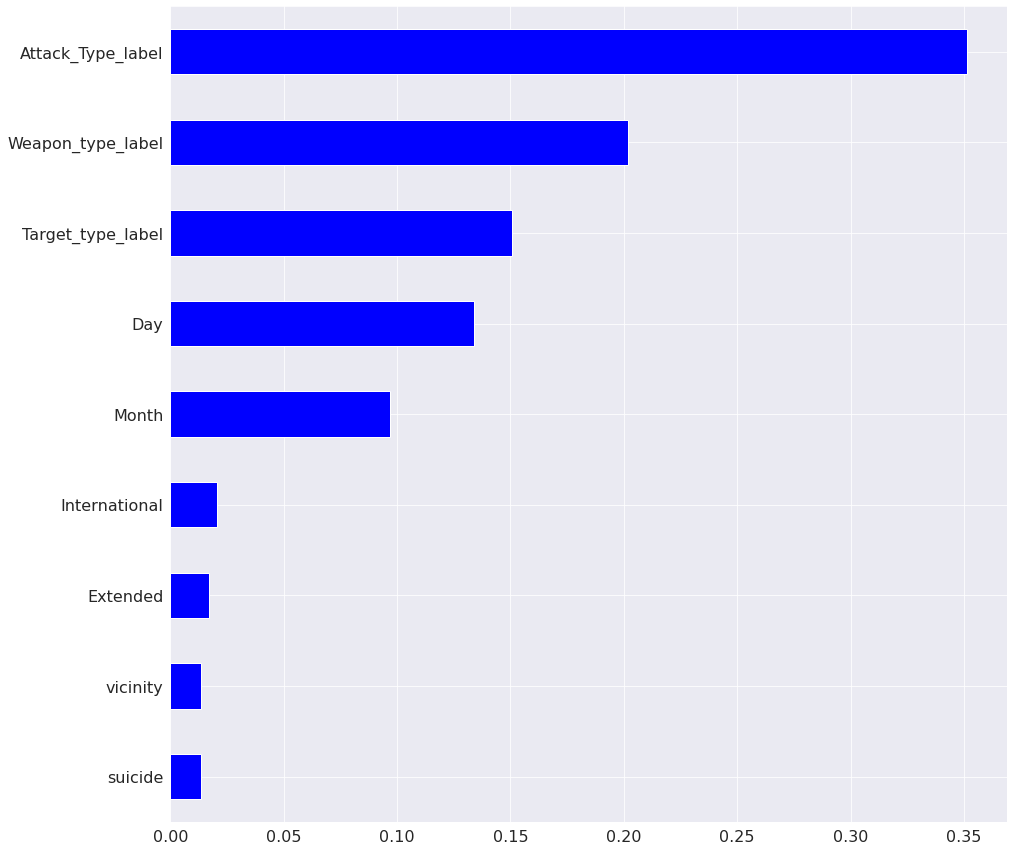

In [80]:
feature_importance = pd.Series(index=X_train.columns, data=model.feature_importances_)
feature_importance = feature_importance.sort_values()
plt.figure(figsize=(15,15))
feature_importance.plot.barh(fontsize=16,color='b' )
plt.show()

The four bottom features don't seem to be very helpful in predicting the successfulness of a terror attack according to the model

<b>Trying out some other models

<b>KNN Model

Best n_neighbors: 3
Best weights: distance
Best Paramaters accuracy score: 0.57


array([[  492,  2403],
       [ 1182, 27895]])

Accuracy Test: 0.888
Accuracy Train: 0.931
              precision    recall  f1-score   support

           0       0.29      0.17      0.22      2895
           1       0.92      0.96      0.94     29077

    accuracy                           0.89     31972
   macro avg       0.61      0.56      0.58     31972
weighted avg       0.86      0.89      0.87     31972



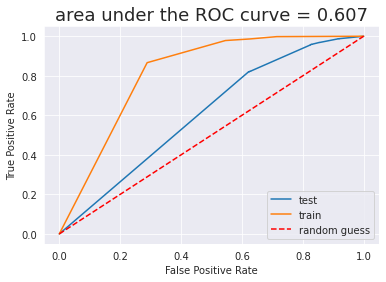

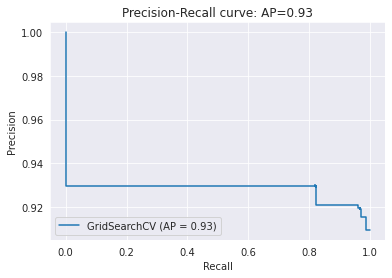

In [81]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors': [3, 5, 7, 10, 13, 16, 21], 'weights':['uniform', 'distance']}
model = GridSearchCV(KNeighborsClassifier(), parameters, scoring='f1_macro', cv=5)
model.fit(X_train, y_train)

# View The Best Parameters
print('Best n_neighbors:', model.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', model.best_estimator_.get_params()['weights'])
print(f'Best Paramaters accuracy score: {round(model.best_score_, 2)}')

get_model_results(model, X_train, X_test, y_train, y_test)

<b>SGDC Classifier</b> - Implementation of both Logistic Regression and LinearSVM

In [82]:
from sklearn.linear_model import SGDClassifier

parameters = {'loss': ['hinge', 'log', 'squared_hinge', 'squared_loss', 'modified_huber'], 'penalty': ['l2', 'l1']}
model = GridSearchCV(SGDClassifier(max_iter=5000), parameters, scoring='f1_macro', cv=5)
model.fit(X_train, y_train)

/home/ariel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ariel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ariel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ariel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
# View The Best Parameters
print('Best loss:', model.best_estimator_.get_params()['loss'])
print('Best penalty:', model.best_estimator_.get_params()['penalty'])
print(f'Best Paramaters f1_macro score: {round(model.best_score_, 2)}')

if 'hinge' in model.best_estimator_.get_params()['loss']:
    get_stats(model, X_train, X_test, y_train, y_test)
else:
    get_model_results(model, X_train, X_test, y_train, y_test)

<b>AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, algorithm = 'SAMME')
model.fit(X_train, y_train)
get_model_results(model, X_train, X_test, y_train, y_test)

In [ ]:
for score in ['f1_macro', 'recall_macro', 'roc_auc']:
    parameters = {'n_estimators':[50,100,150,200]}
    model = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3)), parameters, scoring=score)
    model.fit(X_train.astype(int), y_train)
    get_model_results(model, X_train.astype(int), X_test.astype(int), y_train, y_test)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train.astype(int), y_train)
get_model_results(model, X_train.astype(int), X_test.astype(int), y_train, y_test)

In [ ]:
import xgboost as xgb
feature_importance = pd.Series(index=X_train.columns , data= model.feature_importances_)
feature_importance = feature_importance.sort_values()
feature_importance.tail(20).plot.barh(fontsize=16, figsize=(14,7))
plt.show()

In [ ]:
for score in ['f1_macro', 'recall_macro', 'roc_auc']:
    parameters = {'eta': [0.3, 0.2, 0.1, 0.05], 'max_depth': [3, 5, 7, 10]}
    model = GridSearchCV(XGBClassifier(), parameters, scoring=score)
    model.fit(X_train.astype(int), y_train)
    get_model_results(model, X_train.astype(int), X_test.astype(int), y_train, y_test)

# Motive Bag-of-words Preprocessing

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import spacy
nlp = spacy.load('en')

terror['Motive'].fillna(value='Unknown', inplace=True)

In [ ]:
motives = terror.loc[terror['Motive'].notnull()]['Motive']
motives = motives.str.replace('\n', '').str.replace(';', ' ').str.replace(',',' ').str.replace('.', ' ')

motives = motives.apply(lambda string: ' '.join([word.lemma_.lower() for word in nlp(string)\
              if not word.lemma_.lower() in stopwords.words('english') and not word.lemma_.lower() in punctuation]))

success_words = motives.loc[terror['success'] == '1'].apply(str.lower).apply(str.split).apply(Counter)
failure_words = motives.loc[terror['success'] == '0'].apply(str.lower).apply(str.split).apply(Counter)

In [ ]:
success_dict = Counter()
for dictionary in success_words.values:
    success_dict.update(dictionary)
    
success_dict.most_common(20)

In [ ]:
failure_dict = Counter()
for dictionary in failure_words.values:
    failure_dict.update(dictionary)
    
failure_dict.most_common(20)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
cv = CountVectorizer(stop_words='english', max_features=500, binary=True)
motive_array = cv.fit_transform(motives)
motive_array.shape

In [ ]:
cv.get_feature_names()

In [ ]:
tv = TfidfVectorizer(stop_words='english', max_features=500)
motive_array_tv = tv.fit_transform(motives)
motive_array_tv.shape

In [ ]:
tv.get_feature_names()

We'll try to predict successfulness of an attack solely based on these 'word' features to determine if they provide enough information on their own to be included in the previous models

In [ ]:
target = 'success'
y = terror.loc[terror['Motive'].notnull()][target].astype(int)

X_train_words, X_test_words, y_train_words, y_test_words = \
    train_test_split(motive_array_tv, y, test_size=0.20, random_state=42, stratify=terror.loc[terror['Motive'].notnull()][target])

round(X_train_words.shape[0]/motive_array.shape[0],2), round(X_test_words.shape[0]/motive_array.shape[0], 2)

In [ ]:
word_model = RandomForestClassifier(n_estimators=150, max_depth=12) 
word_model.fit(X_train_words, y_train_words)

get_model_results(word_model, X_train_words, X_test_words, y_train_words, y_test_words)

In [ ]:
from xgboost import XGBClassifier
word_model = XGBClassifier()
word_model.fit(X_train_words, y_train_words)
get_model_results(word_model, X_train_words, X_test_words, y_train_words, y_test_words)

In [ ]:
import xgboost as xgb
feature_importance = pd.Series(index=pd.DataFrame(X_train_words.toarray()).columns , data=word_model.feature_importances_)
feature_importance = feature_importance.sort_values()
feature_importance.tail(20).plot.barh(fontsize=16, figsize=(14,7))
plt.show()

In [ ]:
top_ten = np.argsort(word_model.feature_importances_)[-20::].tolist()
for ind, word in enumerate(top_ten):
    print(f'{20-ind} ranked most important word - "{cv.get_feature_names()[word]}"')

In [ ]:
# for score in ['f1_macro', 'recall_macro', 'roc_auc']:
parameters = {'eta': [0.3, 0.2, 0.1], 'max_depth': [3, 5, 7, 10]}
word_model = GridSearchCV(XGBClassifier(), parameters, scoring='recall_macro')
word_model.fit(X_train_words, y_train_words)
get_model_results(word_model, X_train_words, X_test_words, y_train_words, y_test_words)

In [ ]:
top_ten = np.argsort(word_model.best_estimator_.feature_importances_)[-20::].tolist()
for ind, word in enumerate(top_ten):
    print(f'{20-ind} ranked most important word - "{cv.get_feature_names()[word]}"')

Since we found some words to be impactful for prediction of success we'll use the word feature matrix in the original models and see if they can be improved upon

In [ ]:
features = ['Extended', 'vicinity' ,'Attack_Type', 'Weapon_type',\
            'Target_type', 'International', 'suicide'] #'Month', 'Day']
target = 'success'

X = terror.loc[terror['Motive'].notnull()].loc[:, features]
y = terror.loc[terror['Motive'].notnull()][target].astype(int)

X = pd.concat([X.reset_index(drop=True), pd.DataFrame(motive_array_tv.toarray())], axis=1)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f'Train set size: {round(X_train.shape[0]/len(X),2)*100}%\n\
Test set size: {round(X_test.shape[0]/len(X),2)*100}%')

set(X_train.index) & set(X_test.index)

<b>Categorical values with less than 10% (adjustable) in each category will be combined into the 'Other' category

In [ ]:
threshold = 0.01  
for feat in ['Target_type', 'Weapon_type']:
    temp = (X_train.loc[:, feat].value_counts(normalize=True) > threshold)
    other_list = temp.loc[temp == False].index.tolist()
    
    X_train.loc[:, feat] = X_train.loc[:, feat].apply(lambda x: 'Other' if x in other_list else x)
    X_test.loc[:, feat] = X_test.loc[:, feat].apply(lambda x: 'Other' if x in other_list else x)

<b>Categorical features need to be encoded with one-hot-encoding or labeling, I tested both methods and decided to go with one-hot-encoding to better see correlation to specific categories

In [ ]:
word_features = ['Attack_Type', 'Target_type', 'Weapon_type']
X_train = pd.get_dummies(X_train,columns=word_features)
X_test = pd.get_dummies(X_test,columns=word_features)

y_train, y_test = y_train.astype(int), y_test.astype(int)

In [ ]:
res_model = RandomForestClassifier(n_estimators=150, max_depth=12) 
res_model.fit(X_train, y_train)

get_model_results(res_model, X_train, X_test, y_train, y_test)

In [ ]:
from xgboost import XGBClassifier
word_model = XGBClassifier()
word_model.fit(X_train.astype(int), y_train)
get_model_results(word_model, X_train.astype(int), X_test.astype(int), y_train, y_test)

In [ ]:
# for score in ['f1_macro', 'recall_macro', 'roc_auc']:
parameters = {'eta': [0.3, 0.2, 0.1], 'max_depth': [7, 10, 12, 15]}
word_model = GridSearchCV(XGBClassifier(), parameters, scoring='roc_auc')
word_model.fit(X_train.astype(int), y_train)
get_model_results(word_model, X_train.astype(int), X_test.astype(int), y_train, y_test)

As expected, an XGBoost model gives the best result for this unbalanced dataset with the added complexity of the word features. More work can be done with some dimensionality reduction to only take the most impactful word features.

In [ ]:
# View The Best Parameters
print('Best eta:', word_model.best_estimator_.get_params()['eta'])
print('Best max_depth:', word_model.best_estimator_.get_params()['max_depth'])
print(f'Best Paramaters accuracy score: {round(word_model.best_score_, 2)}')

In [ ]:
word_model = XGBClassifier(eta=0.1, max_depth=7)
word_model.fit(X_train.astype(int), y_train)
get_model_results(word_model, X_train.astype(int), X_test.astype(int), y_train, y_test)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
k_range = range(1, 201, 5)
accuracy = []
roc_auc = []
for k in k_range:
#     features = ['Extended', 'vicinity' ,'Attack_Type', 'Weapon_type',\
#             'Target_type', 'International', 'suicide'] #'Month', 'Day']
#     target = 'success'

#     X = terror.loc[terror['Motive'].notnull()].loc[:, features]
#     y = terror.loc[terror['Motive'].notnull()][target].astype(int)

#     X = pd.concat([X.reset_index(drop=True), pd.DataFrame(motive_array_tv.toarray())], axis=1)

#     X_train, X_test, y_train, y_test = \
#         train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    
    # perform PCA
    pca = PCA(k)
    X_train_pca = pca.fit_transform(X_train.astype(int))
    X_test_pca = pca.transform(X_test.astype(int))
    
    
    
    # Fit and predict using PCA transformed data
    word_model.fit(X_train_pca, y_train)
    y_pred_pca = word_model.predict(X_test_pca)
    accuracy.append(accuracy_score(y_test, y_pred_pca))
    probabilities = word_model.predict_proba(X_test_pca)[:,1]
    roc_auc.append(roc_auc_score(y_test, probabilities))

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(k_range, accuracy, label='Accuracy Score')
plt.title('Model Accuracy vs Number of top features (k)')
plt.xlabel('Number of Top Features from PCA')
plt.ylabel('Model Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(k_range, roc_auc, label='roc_auc_Score')
plt.title('Model Roc_auc_score vs Number of top features (k)')
plt.xlabel('Number of Top Features from PCA')
plt.ylabel('Model Roc_auc_score')
plt.legend()
plt.show()


In [ ]:
np.argmax(roc_auc), np.argmax(accuracy)

In [ ]:
pca = PCA(39)
X_train_pca = pca.fit_transform(X_train.astype(int))
X_test_pca = pca.transform(X_test.astype(int))

# Fit and predict using PCA transformed data
word_model.fit(X_train_pca, y_train)
get_model_results(word_model, X_train_pca, X_test_pca, y_train, y_test)

In [ ]:
import pickle
model_filename = 'terrorism_model.pkl'
# save model to disk
pickle.dump(word_model, open(model_filename, 'wb'))

In [ ]:
from sklearn.dummy import DummyClassifier

random_model = DummyClassifier(strategy="stratified")
random_model.fit(X_train.astype(int), y_train)
get_model_results(random_model, X_train.astype(int), X_test.astype(int), y_train, y_test)